In [4]:
import cv2, imutils, re, sys, math
import xlsxwriter, json, os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from matplotlib import rcParams
import pytesseract
from pytesseract import Output

In [5]:
def findMaxConsecutiveOnes(nums) -> int:
    count = maxCount = 0
    
    for i in range(len(nums)):
        if nums[i] == 1:
            count += 1
        else:
            maxCount = max(count, maxCount)
            count = 0
                
    return max(count, maxCount)

In [6]:
def detectAxes(filepath, threshold=None, debug=False):
    if filepath is None:
        return None, None
    
    if threshold is None:
        threshold = 10
    
    image = cv2.imread(filepath)
    height, width, channels = image.shape
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    maxConsecutiveOnes = [findMaxConsecutiveOnes(gray[:, idx] < 200) for idx in range(width)]
    start_idx, maxindex, maxcount = 0, 0, max(maxConsecutiveOnes)
    while start_idx < width:
        if abs(maxConsecutiveOnes[start_idx] - maxcount) <= threshold:
            maxindex = start_idx
            break
            
        start_idx += 1
           
    yaxis = (maxindex, 0, maxindex, height)
    
    if debug:
        fig, ax = plt.subplots(1, 2)

        ax[0].imshow(image)

        ax[1].plot(maxConsecutiveOnes, color = 'k')
        ax[1].axhline(y = max(maxConsecutiveOnes) - 10, color = 'r', linestyle = 'dashed')
        ax[1].axhline(y = max(maxConsecutiveOnes) + 10, color = 'r', linestyle = 'dashed')
        ax[1].vlines(x = maxindex, ymin = 0.0, ymax = maxConsecutiveOnes[maxindex], color = 'b', linewidth = 4)

        plt.show()

    maxConsecutiveOnes = [findMaxConsecutiveOnes(gray[idx, :] < 200) for idx in range(height)]
    start_idx, maxindex, maxcount = 0, 0, max(maxConsecutiveOnes)
    while start_idx < height:
        if abs(maxConsecutiveOnes[start_idx] - maxcount) <= threshold:
            maxindex = start_idx
            
        start_idx += 1
            
    cv2.line(image, (0, maxindex), (width, maxindex),  (255, 0, 0), 2)
    xaxis = (0, maxindex, width, maxindex)
    
    if debug:
        rcParams['figure.figsize'] = 15, 8

        fig, ax = plt.subplots(1, 1)
        ax.imshow(image, aspect = 'auto')
        
    return xaxis, yaxis

In [17]:
def getTextFromImage(filepath, bw=False, debug=False):
    image_text = []
    
    image = cv2.imread(filepath)
    height, width, _ = image.shape
        
    if bw:
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # define range of black color in HSV
        lower_val = np.array([0, 0, 0])
        upper_val = np.array([179, 255, 179])

        # Threshold the HSV image to get only black colors
        mask = cv2.inRange(hsv, lower_val, upper_val)

        # Bitwise-AND mask and original image
        res = cv2.bitwise_and(image, image, mask = mask)

        # invert the mask to get black letters on white background
        image = cv2.bitwise_not(mask)
            
    d = pytesseract.image_to_data(image, config = "-l eng --oem 1 --psm 11", output_type = Output.DICT)
    n_boxes = len(d['text'])

    # Pick only the positive confidence boxes
    for i in range(n_boxes):
            
        if float(d['conf'][i]) >= 0:
                
            text = d['text'][i].strip()
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            image_text.append((d['text'][i], (x, y, w, h)))
     
    if bw:  
        image = cv2.imread(filepath)
        image_text = list(set(image_text))
        white_bg = 255 * np.ones_like(image)
        
        for text, (textx, texty, w, h) in image_text:
            roi = image[texty:texty + h, textx:textx + w]
            white_bg[texty:texty + h, textx:textx + w] = roi
            
        image_text = []
        d = pytesseract.image_to_data(white_bg, config = "-l eng --oem 1 --psm 11", output_type = Output.DICT)
        n_boxes = len(d['text'])

        # Pick only the positive confidence boxes
        for i in range(n_boxes):

            if int(d['conf'][i]) >= 0:

                text = d['text'][i].strip()
                (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
                image_text.append((d['text'][i], (x, y, w, h)))
        
    # Remove all the duplicates in (text, box) pairs
    return list(set(image_text))

In [18]:
def lineIntersectsRectX(candx, rect):
    (x, y, w, h) = rect
    
    if x <= candx <= x + w:
        return True
    else:
        return False
    
def lineIntersectsRectY(candy, rect):
    (x, y, w, h) = rect
    
    if y <= candy <= y + h:
        return True
    else:
        return False

In [19]:
def cleanText(image_text):
    
    return [(text, (textx, texty, w, h)) for text, (textx, texty, w, h) in image_text if text.strip() != 'I']

In [20]:
def mergeTextBoxes(textboxes):
    rects = []
    rectsUsed = []
    
    # Just initialize bounding rects and set all bools to false
    for box in textboxes:
        rects.append(box)
        rectsUsed.append(False)

    # Sort bounding rects by x coordinate
    def getXFromRect(item):
        return item[1][0]
    
    def getYFromRect(item):
        return item[1][1]

    rects.sort(key = lambda x: (getYFromRect, getXFromRect))
    
    # Array of accepted rects
    acceptedRects = []

    # Merge threshold for x coordinate distance
    xThr = 10
    yThr = 0

    # Iterate all initial bounding rects
    for supIdx, supVal in enumerate(rects):
        if (rectsUsed[supIdx] == False):

            # Initialize current rect
            currxMin = supVal[1][0]
            currxMax = supVal[1][0] + supVal[1][2]
            curryMin = supVal[1][1]
            curryMax = supVal[1][1] + supVal[1][3]
            currText = supVal[0]

            # This bounding rect is used
            rectsUsed[supIdx] = True

            # Iterate all initial bounding rects
            # starting from the next
            for subIdx, subVal in enumerate(rects[(supIdx+1):], start = (supIdx+1)):

                # Initialize merge candidate
                candxMin = subVal[1][0]
                candxMax = subVal[1][0] + subVal[1][2]
                candyMin = subVal[1][1]
                candyMax = subVal[1][1] + subVal[1][3]
                candText = subVal[0]

                # Check if x distance between current rect
                # and merge candidate is small enough
                if (candxMin <= currxMax + xThr):

                    if not nearbyRectangle((candxMin, candyMin, candxMax - candxMin, candyMax - candyMin),
                                           (currxMin, curryMin, currxMax - currxMin, curryMax - curryMin), yThr):
                        break

                    # Reset coordinates of current rect
                    currxMax = candxMax
                    curryMin = min(curryMin, candyMin)
                    curryMax = max(curryMax, candyMax)
                    currText = currText + ' ' + candText
                    
                    # Merge candidate (bounding rect) is used
                    rectsUsed[subIdx] = True
                else:
                    break

            # No more merge candidates possible, accept current rect
            acceptedRects.append([currText, (currxMin, curryMin, currxMax - currxMin, curryMax - curryMin)])
    
    return acceptedRects

In [21]:
def nearbyRectangle(current, candidate, threshold):
    (currx, curry, currw, currh) = current
    (candx, candy, candw, candh) = candidate
    
    currxmin = currx
    currymin = curry
    currxmax = currx + currw
    currymax = curry + currh
    
    candxmin = candx
    candymin = candy
    candxmax = candx + candw
    candymax = candy + candh
    
    # If candidate is on top, and is close
    if candymax <= currymin and candymax + threshold >= currymin:
        return True
    
    # If candidate is on bottom and is close
    if candymin >= currymax and currymax + threshold >= candymin:
        return True
    
    # If intersecting at the top, merge it
    if candymax >= currymin and candymin <= currymin:
        return True
    
    # If intersecting at the bottom, merge it
    if currymax >= candymin and currymin <= candymin:
        return True
    
    # If intersecting on the sides or is inside, merge it
    if (candymin >= currymin and
        candymin <= currymax and
        candymax >= currymin and
        candymax <= currymax):
        return True
    
    return False

In [22]:
def mergeRects(contours):
    rects = []
    rectsUsed = []

    # Just initialize bounding rects and set all bools to false
    for cnt in contours:
        rects.append(cnt)
        #rects.append(cv2.boundingRect(cnt))
        rectsUsed.append(False)

    # Sort bounding rects by x coordinate
    def getXFromRect(item):
        return item[0]

    rects.sort(key = getXFromRect)

    # Array of accepted rects
    acceptedRects = []

    # Merge threshold for x coordinate distance
    xThr = 5
    yThr = 5

    # Iterate all initial bounding rects
    for supIdx, supVal in enumerate(rects):
        if (rectsUsed[supIdx] == False):

            # Initialize current rect
            currxMin = supVal[0]
            currxMax = supVal[0] + supVal[2]
            curryMin = supVal[1]
            curryMax = supVal[1] + supVal[3]

            # This bounding rect is used
            rectsUsed[supIdx] = True

            # Iterate all initial bounding rects
            # starting from the next
            for subIdx, subVal in enumerate(rects[(supIdx+1):], start = (supIdx+1)):

                # Initialize merge candidate
                candxMin = subVal[0]
                candxMax = subVal[0] + subVal[2]
                candyMin = subVal[1]
                candyMax = subVal[1] + subVal[3]

                # Check if x distance between current rect
                # and merge candidate is small enough
                if (candxMin <= currxMax + xThr):

                    if not nearbyRectangle((candxMin, candyMin, candxMax - candxMin, candyMax - candyMin),
                                           (currxMin, curryMin, currxMax - currxMin, curryMax - curryMin), yThr):
                        break

                    # Reset coordinates of current rect
                    currxMax = candxMax
                    curryMin = min(curryMin, candyMin)
                    curryMax = max(curryMax, candyMax)

                    # Merge candidate (bounding rect) is used
                    rectsUsed[subIdx] = True
                else:
                    break

            # No more merge candidates possible, accept current rect
            acceptedRects.append([currxMin, curryMin, currxMax - currxMin, curryMax - curryMin])

    #for rect in acceptedRects:
    #    img = cv2.rectangle(img, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (121, 11, 189), 2)
    
    return acceptedRects

In [23]:
def getProbableYLabels(image, contours, xaxis, yaxis):
    y_labels = []
    
    height, width, channels = image.shape
    
    (x1, y1, x2, y2) = xaxis
    (x11, y11, x22, y22) = yaxis
    
    # Get the y-labels by finding the maximum
    # intersections with the sweeping line
    maxIntersection = 0
    maxList = []
    for i in range(x11):
        count = 0
        current = []
        for index, rect in enumerate(contours):
            if lineIntersectsRectX(i, rect):
                count += 1
                current.append(contours[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
                    
    return image, maxList

In [24]:
def getProbableLabels(image, image_text, xaxis, yaxis):
    y_labels = []
    x_labels = []
    legends = []
    y_text_list = []
    
    height, width, channels = image.shape
    
    (x1, y1, x2, y2) = xaxis
    (x11, y11, x22, y22) = yaxis
    
    image_text = cleanText(image_text)
    
    for text, (textx, texty, w, h) in image_text:
        text = text.strip()
            
        # To the left of y-axis and top of x-axis
        if (np.sign((x2 - x1) * (texty - y1) - (y2 - y1) * (textx - x1)) == -1 and
            np.sign((x22 - x11) * (texty - y11) - (y22 - y11) * (textx - x11)) == 1):
            
            numbers = re.findall(r'^[+-]?\d+(?:\.\d+)?[%-]?$', text)
            if bool(numbers):
                y_labels.append((text, (textx, texty, w, h)))
            else:
                y_text_list.append((text, (textx, texty, w, h)))
            
        # To the right of y-axis and bottom of x-axis
        elif (np.sign((x2 - x1) * (texty - y1) - (y2 - y1) * (textx - x1)) == 1 and
            np.sign((x22 - x11) * (texty - y11) - (y22 - y11) * (textx - x11)) == -1):
            x_labels.append((text, (textx, texty, w, h)))
            
        # Top of x-axis and to the right of y-axis
        elif (np.sign((x2 - x1) * (texty - y1) - (y2 - y1) * (textx - x1)) == -1 and
            np.sign((x22 - x11) * (texty - y11) - (y22 - y11) * (textx - x11)) == -1):
            
            # Consider non-numeric only for legends
            legends.append((text, (textx, texty, w, h)))
    
    # Get the y-labels by finding the maximum
    # intersections with the sweeping line
    maxIntersection = 0
    maxList = []
    for i in range(x11):
        count = 0
        current = []
        for index, (text, rect) in enumerate(y_labels):
            if lineIntersectsRectX(i, rect):
                count += 1
                current.append(y_labels[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
    
    y_labels_list = maxList.copy()
    
    y_labels = []
    for text, (textx, texty, w, h) in maxList:
        y_labels.append(text)
        
    # Get the x-labels by finding the maximum
    # intersections with the sweeping line
    
    maxIntersection = 0
    maxList = []
    for i in range(y1, height):
        count = 0
        current = []
        for index, (text, rect) in enumerate(x_labels):
            if lineIntersectsRectY(i, rect):
                count += 1
                current.append(x_labels[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
            
    x_labels_list = maxList.copy()
    
    x_text = x_labels.copy()
    x_labels = []
    hmax = 0
    
    for text, (textx, texty, w, h) in maxList:
        x_labels.append(text)
        if texty + h > hmax:
            hmax = texty + h
    
    # Get possible x-text by moving from where we
    # left off in x-labels to the complete
    # height of the image.
    maxIntersection = 0
    maxList = []
    for i in range(hmax + 1, height):
        count = 0
        current = []
        for index, (text, rect) in enumerate(x_text):
            if lineIntersectsRectY(i, rect):
                count += 1
                current.append(x_text[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
    
    x_text = []
    for text, (textx, texty, w, h) in maxList:
        x_text.append(text)
    
    # Get possible legend text
    # For this, we need to search both top to
    # bottom and also from left to right.
    
    legends_and_numbers = mergeTextBoxes(legends)
    
    legends = []
    for text, (textx, texty, w, h) in legends_and_numbers:
        if not re.search(r'^([(+-]*?(\d+)?(?:\.\d+)*?[-%) ]*?)*$', text):
            legends.append((text, (textx, texty, w, h)))
    
    
    def canMerge(group, candidate):
        candText, candRect = candidate
        candx, candy, candw, candh = candRect
        
        for memText, memRect in group:
            memx, memy, memw, memh = memRect
                
            if abs(candy - memy) <= 5 and abs(candy + candh - memy - memh) <= 5:
                return True
            elif abs(candx - memx) <= 5:
                return True
                
        return False
    
    # Grouping Algorithm
    legend_groups = []
    for index, (text, rect) in enumerate(legends):
        #print("text: {0}, rect: {1}\n".format(text, rect))
        
        for groupid, group in enumerate(legend_groups):
            if canMerge(group, (text, rect)):
                group.append((text, rect))
                break
        else:
            legend_groups.append([(text, rect)])
    
    #print(legend_groups)
    #print("\n\n")
    
    maxList = []
    
    if len(legend_groups) > 0:
        maxList = max(legend_groups, key = len)

    legends = []
    for text, (textx, texty, w, h) in maxList:
        legends.append(text)
        
    return image, x_labels, x_labels_list, x_text, y_labels, y_labels_list, y_text_list, legends, maxList

['400', '1000', '900', '600', '500', '700', '800']
['25', '35', '20', '30', '10', '15']
[('400', (194, 687, 44, 22)), ('1000', (942, 687, 58, 22)), ('900', (822, 687, 45, 22)), ('600', (445, 687, 45, 22)), ('500', (320, 687, 44, 22)), ('700', (571, 687, 44, 22)), ('800', (697, 687, 44, 22))]
[('25', (39, 186, 29, 21)), ('35', (39, 0, 29, 21)), ('20', (39, 279, 29, 21)), ('30', (39, 93, 29, 21)), ('10', (42, 465, 26, 21)), ('15', (41, 372, 27, 21))]
['—~e—', '—', '——']
[('—~e—', (514, 110, 75, 28)), ('—', (518, 50, 67, 14)), ('——', (518, 74, 71, 29))]


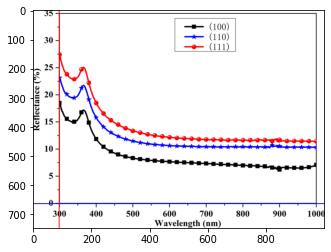

In [29]:
file_path = './img_8.png'
xaxis, yaxis = detectAxes(file_path)
# show Axes

image = cv2.imread(file_path)
for (x1, y1, x2, y2) in [xaxis]:
    cv2.line(image, (x1, y1), (x2, y2),  (0, 0, 255), 2)

for (x1, y1, x2, y2) in [yaxis]:
    cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
plt.imshow(image)
plt.show
# cv2.imwrite(save_dir + '/' + ''.join(path.name.split(".")[:-1]) + "_axes.png", image)

# extract text
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
image_text = getTextFromImage(file_path)
image, x_labels, x_labels_list, x_text, y_labels, y_labels_list, y_text_list, legends, maxList = getProbableLabels(image, image_text, xaxis, yaxis)
print(x_labels)
print(y_labels)
print(x_labels_list)
print(y_labels_list)
print(legends)
print(maxList)

In [28]:
import pytesseract
from PIL import Image
# 读取图片
im = Image.open('./img_6.png')
# 识别文字
string = pytesseract.image_to_string(im)
print(string)

J, (mA/cm’)

—AI,O, 600°C Annealed

—— AI,0, 450°C Annealed
— AI,O, 300°C Annealed
— AI,O, Without Annealing
— — SiN, Control Sample

100 200 300 400
V.. (mV)

500

 

600



In [59]:
# Python program to illustrate HoughLine
# method for line detection
import cv2
import numpy as np
  
# Reading the required image in 
# which operations are to be done. 
# Make sure that the image is in the same 
# directory in which this python program is
img = cv2.imread('./img_pdf.jpg')
  
# Convert the img to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  
# Apply edge detection method on the image
edges = cv2.Canny(gray,50,150,apertureSize = 3)
  
# This returns an array of r and theta values
lines = cv2.HoughLines(edges,1,np.pi/180, 200)
  
# The below for loop runs till r and theta values 
# are in the range of the 2d array
for r,theta in lines[0]:
      
    # Stores the value of cos(theta) in a
    a = np.cos(theta)
  
    # Stores the value of sin(theta) in b
    b = np.sin(theta)
      
    # x0 stores the value rcos(theta)
    x0 = a*r
      
    # y0 stores the value rsin(theta)
    y0 = b*r
      
    # x1 stores the rounded off value of (rcos(theta)-1000sin(theta))
    x1 = int(x0 + 1000*(-b))
      
    # y1 stores the rounded off value of (rsin(theta)+1000cos(theta))
    y1 = int(y0 + 1000*(a))
  
    # x2 stores the rounded off value of (rcos(theta)+1000sin(theta))
    x2 = int(x0 - 1000*(-b))
      
    # y2 stores the rounded off value of (rsin(theta)-1000cos(theta))
    y2 = int(y0 - 1000*(a))
      
    # cv2.line draws a line in img from the point(x1,y1) to (x2,y2).
    # (0,0,255) denotes the colour of the line to be 
    #drawn. In this case, it is red. 
    cv2.line(img,(x1,y1), (x2,y2), (0,0,255),2)
      
# All the changes made in the input image are finally
# written on a new image houghlines.jpg
cv2.imwrite('linesDetected.jpg', img)

True